In [1]:
# Imports
import torch
import torchvision
from torchvision.datasets import MNIST

In [2]:
# Download training dataset
dataset = MNIST(root='data/', download=True)

In [3]:
len(dataset)

60000

In [4]:
# additional test set of 10000 images
test_dataset = MNIST(root='data/', train=False)
len(test_dataset)

10000

In [5]:
dataset[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x12261C9E8>, 5)

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

Label: 5


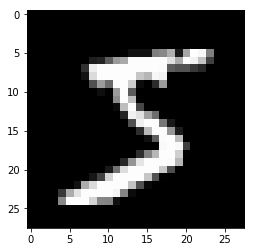

In [7]:
image, label = dataset[0]
plt.imshow(image)
print('Label:', label)

Label: 3


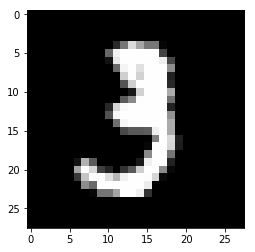

In [8]:
image, label = dataset[10]
plt.imshow(image)
print('Label:', label)

In [9]:
# Use the ToTensor transform to convert images into PyTorch tensors
import torchvision.transforms as transforms

In [10]:
# MNIST dataset (images and labels)
dataset = MNIST(root='data/', 
                train=True,
                transform=transforms.ToTensor())

In [11]:
img_tensor, label = dataset[0]
print(img_tensor.shape, label)

torch.Size([1, 28, 28]) 5


In [12]:
# Sample values inside the tensor
print(img_tensor[:,10:15,10:15])
print(torch.max(img_tensor), torch.min(img_tensor))

tensor([[[0.0039, 0.6039, 0.9922, 0.3529, 0.0000],
         [0.0000, 0.5451, 0.9922, 0.7451, 0.0078],
         [0.0000, 0.0431, 0.7451, 0.9922, 0.2745],
         [0.0000, 0.0000, 0.1373, 0.9451, 0.8824],
         [0.0000, 0.0000, 0.0000, 0.3176, 0.9412]]])
tensor(1.) tensor(0.)


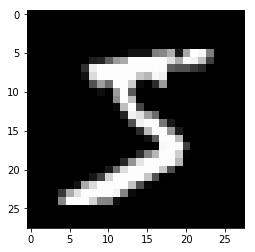

In [13]:
# Plot the image by passing in the 28x28 matrix
plt.imshow(img_tensor[0], cmap='gray');

# Training and Validation Datasets

#### Split the dataset into 3 parts:
#### 1. Training set - used to train the model i.e. compute the loss and adjust the weights of the model using gradient descent.
#### 2. Validation set - used to evaluate the model while training, adjust hyperparameters (learning rate etc.) and pick the best version of the model.
#### 3. Test set - used to compare different models, or different types of modeling approaches, and report the final accuracy of the model.

### Let's define a function that randomly picks a given fraction of the images for the validation set.

#### split_indcies randomly shuffles the array indices 0,1,..n-1, and separates out a desired portion from it for the validation set;
#### If we were to pick a 20% validation set simply by selecting the last 20% of the images, the validation set would only consist of images of 8s and 9s, whereas the training set would contain no images of 8s and 9s. This would make it impossible to train a good model using the training set, which also performs well on the validation set (and on real world data).

In [14]:
import numpy as np

def split_indices(n, val_pct):
    # Determine size of validation set
    n_val = int(val_pct*n)
    # Create random permutation of 0 to n-1
    idxs = np.random.permutation(n)
    # Pick first n_val indices for validation set
    return idxs[n_val:], idxs[:n_val]

In [15]:
train_indices, val_indices = split_indices(len(dataset), val_pct=0.2)

In [16]:
print(len(train_indices), len(val_indices))
print('Sample val indices: ', val_indices[:20])

48000 12000
Sample val indices:  [54128 23980 55895  5380 46109 57208 18925 56638 25474 29490  6458  8262
 12936 39764  1286 13398 55476 28178 56972 34897]


In [17]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

In [18]:
batch_size=100

# Training sampler and data loader
train_sampler = SubsetRandomSampler(train_indices)
train_loader = DataLoader(dataset, 
                          batch_size, 
                          sampler=train_sampler)

# Validation sampler and data loader
val_sampler = SubsetRandomSampler(val_indices)
val_loader = DataLoader(dataset,
                        batch_size, 
                        sampler=val_sampler)

# Model

In [19]:
import torch.nn as nn

input_size = 28*28
num_classes = 10

# Logistic regression model
model = nn.Linear(input_size, num_classes)

In [20]:
print(model.weight.shape)
model.weight

torch.Size([10, 784])


Parameter containing:
tensor([[-0.0183, -0.0340,  0.0164,  ..., -0.0086, -0.0075, -0.0356],
        [-0.0211, -0.0166, -0.0157,  ..., -0.0184, -0.0133, -0.0203],
        [ 0.0006,  0.0185, -0.0080,  ...,  0.0032,  0.0154, -0.0022],
        ...,
        [ 0.0088, -0.0129, -0.0142,  ..., -0.0056, -0.0298,  0.0144],
        [ 0.0278, -0.0295, -0.0211,  ..., -0.0313,  0.0052,  0.0204],
        [ 0.0107, -0.0184,  0.0102,  ...,  0.0266, -0.0293, -0.0163]],
       requires_grad=True)

In [21]:
print(model.bias.shape)
model.bias

torch.Size([10])


Parameter containing:
tensor([ 0.0043, -0.0254, -0.0339, -0.0086, -0.0095,  0.0135,  0.0034,  0.0025,
         0.0164, -0.0043], requires_grad=True)

#### Take the first batch of 100 images from our dataset, and pass them into our model.

In [22]:
for images, labels in train_loader:
    print(images.shape)
    outputs = model(images)
    break

torch.Size([100, 1, 28, 28])


RuntimeError: size mismatch, m1: [2800 x 28], m2: [784 x 10] at /Users/soumith/mc3build/conda-bld/pytorch_1549597882250/work/aten/src/TH/generic/THTensorMath.cpp:940

####  Need to flatten them out. We'll use the .reshape method of a tensor, which will allow us to efficiently 'view' each image as a flat vector, without really chaging the underlying data.
####  We need to define a custom model, by extending the nn.Module class from PyTorch.

In [23]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
model = MnistModel()

In [24]:
print(model.linear.weight.shape, model.linear.bias.shape)
list(model.parameters())

torch.Size([10, 784]) torch.Size([10])


[Parameter containing:
 tensor([[ 0.0337, -0.0281,  0.0173,  ...,  0.0156, -0.0325, -0.0291],
         [-0.0251,  0.0127, -0.0296,  ..., -0.0144,  0.0014,  0.0089],
         [-0.0250, -0.0238,  0.0299,  ...,  0.0205,  0.0054,  0.0241],
         ...,
         [ 0.0135,  0.0035, -0.0191,  ...,  0.0331, -0.0036,  0.0009],
         [ 0.0096,  0.0186, -0.0162,  ...,  0.0273, -0.0356,  0.0069],
         [-0.0099, -0.0126,  0.0312,  ...,  0.0106,  0.0200,  0.0136]],
        requires_grad=True), Parameter containing:
 tensor([-0.0037,  0.0054, -0.0286, -0.0156, -0.0150,  0.0188,  0.0026, -0.0002,
         -0.0247, -0.0284], requires_grad=True)]

In [25]:
for images, labels in train_loader:
    outputs = model(images)
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

outputs.shape :  torch.Size([100, 10])
Sample outputs :
 tensor([[ 0.1252, -0.0994, -0.0475, -0.0804,  0.0766, -0.0439,  0.1159, -0.2478,
         -0.1140, -0.1183],
        [-0.3592,  0.0152,  0.1861,  0.1564, -0.0375,  0.0082,  0.1836,  0.1035,
         -0.1328,  0.1973]])


In [26]:
import torch.nn.functional as F

In [27]:
# Apply softmax for each output row
probs = F.softmax(outputs, dim=1)

# Look at sample probabilities
print("Sample probabilities:\n", probs[:2].data)

# Add up the probabilities of an output row
print("Sum: ", torch.sum(probs[0]).item())

Sample probabilities:
 tensor([[0.1176, 0.0940, 0.0990, 0.0958, 0.1120, 0.0993, 0.1165, 0.0810, 0.0926,
         0.0922],
        [0.0667, 0.0970, 0.1151, 0.1118, 0.0921, 0.0964, 0.1148, 0.1060, 0.0837,
         0.1164]])
Sum:  0.9999999403953552


In [28]:
max_probs, preds = torch.max(probs, dim=1)
print(preds)

tensor([0, 9, 6, 5, 4, 6, 2, 6, 0, 2, 4, 2, 6, 6, 5, 5, 6, 6, 7, 6, 2, 0, 2, 3,
        2, 4, 5, 6, 2, 3, 6, 9, 5, 0, 6, 3, 2, 7, 4, 0, 5, 6, 6, 9, 6, 3, 6, 5,
        7, 6, 3, 1, 6, 6, 7, 6, 2, 6, 2, 6, 3, 2, 1, 2, 3, 4, 2, 2, 1, 3, 2, 7,
        6, 6, 4, 5, 0, 0, 2, 9, 6, 6, 0, 1, 3, 3, 6, 2, 6, 2, 6, 6, 6, 6, 2, 6,
        6, 7, 5, 0])


In [29]:
labels

tensor([3, 4, 7, 1, 8, 4, 1, 9, 3, 1, 2, 6, 7, 7, 3, 7, 1, 6, 4, 0, 1, 0, 4, 4,
        4, 6, 1, 0, 3, 3, 2, 7, 3, 1, 2, 6, 7, 3, 3, 3, 9, 1, 8, 9, 2, 4, 6, 5,
        4, 0, 6, 8, 0, 7, 7, 9, 3, 7, 7, 3, 7, 9, 9, 1, 8, 0, 1, 6, 4, 2, 1, 4,
        6, 0, 2, 1, 3, 5, 4, 8, 8, 2, 9, 0, 9, 8, 0, 9, 1, 7, 0, 4, 7, 6, 8, 9,
        0, 9, 3, 5])

# Evaluation Metric and Loss Function

In [30]:
def accuracy(l1, l2):
    return torch.sum(l1 == l2).item() / len(l1)

In [31]:
accuracy(preds, labels)

0.09

In [32]:
loss_fn = F.cross_entropy

In [33]:
# Loss for current batch of data
loss = loss_fn(outputs, labels)
print(loss)

tensor(2.3030, grad_fn=<NllLossBackward>)


# Optimizer

In [34]:
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Training the model

In [35]:
def loss_batch(model, loss_func, xb, yb, opt=None, metric=None):
    # Calculate loss
    preds = model(xb)
    loss = loss_func(preds, yb)
                     
    if opt is not None:
        # Compute gradients
        loss.backward()
        # Update parameters             
        opt.step()
        # Reset gradients
        opt.zero_grad()
    
    metric_result = None
    if metric is not None:
        # Compute the metric
        metric_result = metric(preds, yb)
    
    return loss.item(), len(xb), metric_result

In [36]:
def evaluate(model, loss_fn, valid_dl, metric=None):
    with torch.no_grad():
        # Pass each batch through the model
        results = [loss_batch(model, loss_fn, xb, yb, metric=metric)
                   for xb,yb in valid_dl]
        # Separate losses, counts and metrics
        losses, nums, metrics = zip(*results)
        # Total size of the dataset
        total = np.sum(nums)
        # Avg. loss across batches 
        avg_loss = np.sum(np.multiply(losses, nums)) / total
        avg_metric = None
        if metric is not None:
            # Avg. of metric across batches
            avg_metric = np.sum(np.multiply(metrics, nums)) / total
    return avg_loss, total, avg_metric

In [37]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.sum(preds == labels).item() / len(preds)

In [38]:
val_loss, total, val_acc = evaluate(model, loss_fn, val_loader, metric=accuracy)
print('Loss: {:.4f}, Accuracy: {:.4f}'.format(val_loss, val_acc))

Loss: 2.3042, Accuracy: 0.1146


In [39]:
def fit(epochs, model, loss_fn, opt, train_dl, valid_dl, metric=None):
    for epoch in range(epochs):
        # Training
        for xb,yb in train_dl:
            loss,_,_ = loss_batch(model, loss_fn, xb, yb, opt)

        # Evaluation
        result = evaluate(model, loss_fn, valid_dl, metric)
        val_loss, total, val_metric = result
        
        # Print progress
        if metric is None:
            print('Epoch [{}/{}], Loss: {:.4f}'
                  .format(epoch+1, epochs, val_loss))
        else:
            print('Epoch [{}/{}], Loss: {:.4f}, {}: {:.4f}'
                  .format(epoch+1, epochs, val_loss, metric.__name__, val_metric))

In [40]:
# Redifine model and optimizer
model = MnistModel()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [41]:
fit(5, model, F.cross_entropy, optimizer, train_loader, val_loader, accuracy)

Epoch [1/5], Loss: 1.8918, accuracy: 0.6421
Epoch [2/5], Loss: 1.5911, accuracy: 0.7478
Epoch [3/5], Loss: 1.3794, accuracy: 0.7752
Epoch [4/5], Loss: 1.2273, accuracy: 0.7949
Epoch [5/5], Loss: 1.1146, accuracy: 0.8048


In [42]:
fit(5, model, F.cross_entropy, optimizer, train_loader, val_loader, accuracy)

Epoch [1/5], Loss: 1.0283, accuracy: 0.8133
Epoch [2/5], Loss: 0.9604, accuracy: 0.8202
Epoch [3/5], Loss: 0.9056, accuracy: 0.8267
Epoch [4/5], Loss: 0.8604, accuracy: 0.8323
Epoch [5/5], Loss: 0.8224, accuracy: 0.8364


In [43]:
fit(5, model, F.cross_entropy, optimizer, train_loader, val_loader, accuracy)

Epoch [1/5], Loss: 0.7901, accuracy: 0.8403
Epoch [2/5], Loss: 0.7622, accuracy: 0.8439
Epoch [3/5], Loss: 0.7378, accuracy: 0.8465
Epoch [4/5], Loss: 0.7164, accuracy: 0.8495
Epoch [5/5], Loss: 0.6973, accuracy: 0.8524


In [44]:
fit(5, model, F.cross_entropy, optimizer, train_loader, val_loader, accuracy)

Epoch [1/5], Loss: 0.6802, accuracy: 0.8537
Epoch [2/5], Loss: 0.6648, accuracy: 0.8557
Epoch [3/5], Loss: 0.6508, accuracy: 0.8572
Epoch [4/5], Loss: 0.6380, accuracy: 0.8580
Epoch [5/5], Loss: 0.6264, accuracy: 0.8593


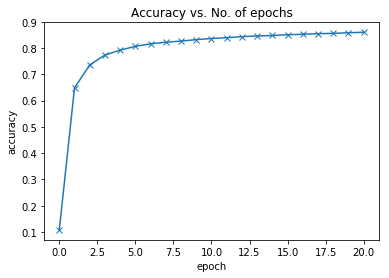

In [45]:
# Replace these values with your results
accuracies = [0.1076, 0.6486, 0.7362, 0.7737, 0.7925, 0.8069, 
              0.8165, 0.8227, 0.8269, 0.8325, 0.8367,
              0.8399, 0.8438, 0.8463, 0.8482, 0.8512,
              0.8529, 0.8552, 0.8563, 0.8587, 0.8606]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

# Testing with individual images

In [46]:
# Define test dataset
test_dataset = MNIST(root='data/', 
                     train=False,
                     transform=transforms.ToTensor())

Shape: torch.Size([1, 28, 28])
Label: 7


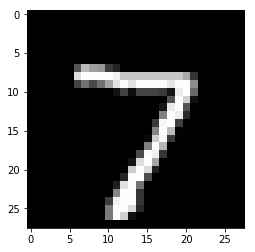

In [48]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Shape:', img.shape)
print('Label:', label)

In [49]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 7 , Predicted: 7


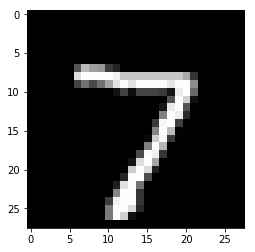

In [51]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 0 , Predicted: 0


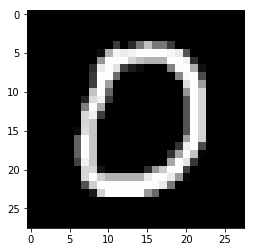

In [52]:
img, label = test_dataset[10]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 9 , Predicted: 4


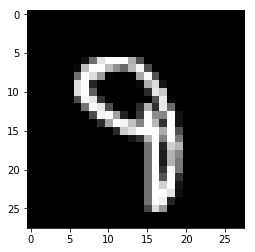

In [53]:
img, label = test_dataset[193]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 3 , Predicted: 5


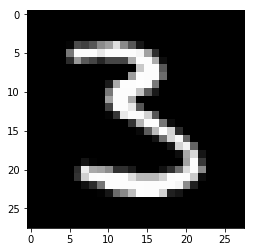

In [54]:
img, label = test_dataset[1889]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

In [55]:
test_loader = DataLoader(test_dataset, batch_size=200)

test_loss, total, test_acc = evaluate(model, loss_fn, test_loader, metric=accuracy)
print('Loss: {:.4f}, Accuracy: {:.4f}'.format(test_loss, test_acc))

Loss: 0.5972, Accuracy: 0.8676


# Saving and loading the model

In [56]:
torch.save(model.state_dict(), 'mnist-logistic.pth')

In [57]:
model.state_dict()

OrderedDict([('linear.weight',
              tensor([[-0.0127,  0.0332, -0.0012,  ...,  0.0311,  0.0260,  0.0067],
                      [ 0.0177,  0.0300, -0.0170,  ..., -0.0198, -0.0347, -0.0154],
                      [ 0.0281,  0.0174,  0.0108,  ..., -0.0072,  0.0223,  0.0121],
                      ...,
                      [-0.0063, -0.0175,  0.0203,  ..., -0.0357, -0.0342,  0.0124],
                      [ 0.0064, -0.0103,  0.0250,  ...,  0.0281, -0.0113, -0.0104],
                      [ 0.0062, -0.0296, -0.0095,  ..., -0.0049,  0.0290,  0.0017]])),
             ('linear.bias',
              tensor([-0.0565,  0.0936, -0.0235, -0.0084,  0.0056,  0.0324, -0.0214,  0.0687,
                      -0.1216, -0.0334]))])

In [58]:
model2 = MnistModel()
model2.load_state_dict(torch.load('mnist-logistic.pth'))
model2.state_dict()

OrderedDict([('linear.weight',
              tensor([[-0.0127,  0.0332, -0.0012,  ...,  0.0311,  0.0260,  0.0067],
                      [ 0.0177,  0.0300, -0.0170,  ..., -0.0198, -0.0347, -0.0154],
                      [ 0.0281,  0.0174,  0.0108,  ..., -0.0072,  0.0223,  0.0121],
                      ...,
                      [-0.0063, -0.0175,  0.0203,  ..., -0.0357, -0.0342,  0.0124],
                      [ 0.0064, -0.0103,  0.0250,  ...,  0.0281, -0.0113, -0.0104],
                      [ 0.0062, -0.0296, -0.0095,  ..., -0.0049,  0.0290,  0.0017]])),
             ('linear.bias',
              tensor([-0.0565,  0.0936, -0.0235, -0.0084,  0.0056,  0.0324, -0.0214,  0.0687,
                      -0.1216, -0.0334]))])

In [59]:
test_loss, total, test_acc = evaluate(model, loss_fn, test_loader, metric=accuracy)
print('Loss: {:.4f}, Accuracy: {:.4f}'.format(test_loss, test_acc))

Loss: 0.5972, Accuracy: 0.8676
